<h1 align=center><font size = 6>Online retail shop customers clustering</font></h1>

The purpose of this notebook is to analyze the sales of an online retail store for a year, in order to be able to define what groups of clients they have and thus be able to launch personalized marketing campaigns. We will pay attention to three variables: the amount of purchases, the number of products purchased and the time elapsed since the last purchase.

For this we will use a clustering model based on KMeans.

__IMPORTANT NOTE__: This notebook was made by __Alejandro Velázquez Portas__ (<a href="https://www.linkedin.com/in/alexvelazquezp/">LinkedIn profile</a>). Take this into account when reproducing or citing its content.

In [71]:
import pandas as pd
import numpy as np
import datetime as datetime
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# 1. Data
## 1.1. Data import

Let's read the Excel file that contains the information:

In [72]:
df = pd.read_excel('Online Retail.xlsx')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [73]:
df.shape

(541909, 8)

The dataset consists of a total of 541909 rows and 8 columns, but as we will see in the next subsection, we will not handle all this information.

## 1.2. Data wrangling

Let's take a look to the data types and null values:

In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


Since the number of rows is 541909, all those columns that do not have this value in non-null count column will have null values. Description and CustomerID columns seems to be affected.

In [75]:
print('There are {} invoice without product description information'.format(df['Description'].isnull().sum()))
print('There are {} invoice without customer ID information'.format(df['CustomerID'].isnull().sum()))

There are 1454 invoice without product description information
There are 135080 invoice without customer ID information


As we have explained previously, number of purchases, amount and days after the last purchase will be our variables, so not knowing what product has been purchased will not be an issue. Therefore, we will only need to delete the data wihtout Customer ID.

In [76]:
df = df[df['CustomerID'].notna()]
df.shape

(406829, 8)

Note that the Customer ID data appears as a decimal number, so let's convert them:

In [77]:
df = df.astype({'CustomerID':object})
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


## 1.3. Calculated values

### 1.3.1. Frequency

Let's start calculating the number of purchases made by each client: 

In [78]:
frequency = df.groupby('CustomerID').count()
frequency = frequency[['InvoiceNo']]
frequency.reset_index(inplace=True)
frequency = frequency.astype({'CustomerID':object})
frequency.rename(columns={'InvoiceNo':'Frequency'}, inplace=True)
frequency.head()

,CustomerID,Frequency
0,12346,2
1,12347,182
2,12348,31
3,12349,73
4,12350,17


### 1.3.2. Amount

We will repeat the same process for the total amount:

In [79]:
df['Sold'] = df['Quantity'] * df['UnitPrice']
amount = df.groupby('CustomerID').sum()
amount = amount[['Sold']]
amount.reset_index(inplace=True)
amount = amount.astype({'CustomerID':object})
amount.head()

,CustomerID,Sold
0,12346,0.00
1,12347,4310.00
2,12348,1797.24
3,12349,1757.55
4,12350,334.40


### 1.3.3. Last buy

And finally we will calculated how many days have passed since the last purchase:

In [80]:
last = df['InvoiceDate'].max()
df['Days'] = last - df['InvoiceDate']
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sold,Days
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,373 days 04:24:00


In [81]:
lastbuy = df[['CustomerID','Days']].groupby('CustomerID').min()
lastbuy.reset_index(inplace=True)
lastbuy['Days'] = lastbuy['Days'].dt.days
lastbuy.head()

,CustomerID,Days
0,12346.0,325
1,12347.0,1
2,12348.0,74
3,12349.0,18
4,12350.0,309


## 1.4. Retail dataset

We will merge frequency, amount and last buy data into a single dataframe, that we will later use for our model.

In [82]:
df_fre_amo = pd.merge(how='inner', left=frequency, right=amount, left_on='CustomerID', right_on='CustomerID')
retail = pd.merge(how='inner', left=df_fre_amo, right=lastbuy, left_on='CustomerID', right_on='CustomerID')
retail.head()

,CustomerID,Frequency,Sold,Days
0,12346,2,0.00,325
1,12347,182,4310.00,1
2,12348,31,1797.24,74
3,12349,73,1757.55,18
4,12350,17,334.40,309


It's almost ready. We can check if there are any null value in our dataset:

In [83]:
retail.isnull().sum().sum()

0

We can review a data summary too:

In [84]:
retail.describe()

,Frequency,Sold,Days
count,4372.000000,4372.000000,4372.000000
mean,93.053294,1898.459701,91.047118
std,232.471608,8219.345141,100.765435
min,1.000000,-4287.630000,0.000000
25%,17.000000,293.362500,16.000000
50%,42.000000,648.075000,49.000000
75%,102.000000,1611.725000,142.000000
max,7983.000000,279489.020000,373.000000


Take a look to the previous table.

There minimum value for Sold column is a negative number. What can it be due to? Sometimes customers return products. If the product was purchased and returned within the evaluated period, the amount will be zero, but if it has been purchased in a previous period and returned in this period, the result will be negative.


Faced with this problem we can act in different ways, often being a decision that will correspond to the retail company. In this example we are going to delete all customers with negative amounts and those equal to zero.

In [85]:
print('There are {} values equal or less than zero'.format(len(retail[retail['Sold'] <= 0])))
retail[retail['Sold'] <= 0].head()

There are 50 values equal or less than zero


,CustomerID,Frequency,Sold,Days
0,12346,2,0.000000e+00,325
89,12454,30,-5.684342e-14,52
125,12503,1,-1.126000e+03,337
127,12505,1,-4.500000e+00,300
212,12605,3,-7.500000e+00,364


In [86]:
retail = retail[retail['Sold'] > 0]
retail.reset_index(inplace=True, drop=True)

## 1.5. Outliers

Let's explode each category using boxplots:

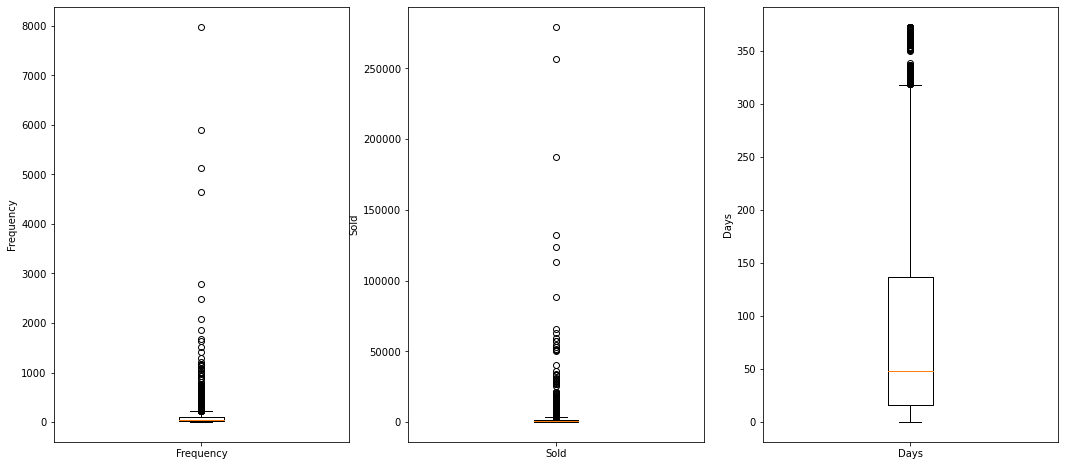

In [87]:
columns = ['Frequency', 'Sold', 'Days']
fig, axes = plt.subplots(1,3)
fig.set_size_inches(18,8)

for i,ax in enumerate(axes.flatten()):
    col=columns[i]
    ax.boxplot(retail[col], labels=[col])
    ax.set_ylabel(col)
    
plt.show()

As figures show, the number of outliers is huge. Outliers are calculated as values between (Q1 - 1.5 * IQR) and (Q3 + 1.5 * IQR), where Q1 is the 25% quantile, Q3 is 75% quantile and IQR is the difference between Q3 and Q1.

So, our number of outliers is the following:

In [88]:
#For Frequency column's outliers
Q3 = retail['Frequency'].quantile(0.75)
Q1 = retail['Frequency'].quantile(0.25)
IQR = Q3 - Q1
freq_outliers = len(retail[(retail['Frequency'] < (Q1-1.5*IQR)) | (retail['Frequency'] > (Q3+1.5*IQR))])
print('There are {} outliers in Frequency values ({:.2f}%)'.format(freq_outliers, (freq_outliers/len(retail))*100))

#For Sold column's outliers
Q3 = retail['Sold'].quantile(0.75)
Q1 = retail['Sold'].quantile(0.25)
IQR = Q3 - Q1
sold_outliers = len(retail[(retail['Sold'] < (Q1-1.5*IQR)) | (retail['Sold'] > (Q3+1.5*IQR))])
print('There are {} outliers in Sold values ({:.2f}%)'.format(sold_outliers, (sold_outliers/len(retail))*100))

#For Days column's outliers
Q3 = retail['Days'].quantile(0.75)
Q1 = retail['Days'].quantile(0.25)
IQR = Q3 - Q1
days_outliers = len(retail[(retail['Days'] < (Q1-1.5*IQR)) | (retail['Days'] > (Q3+1.5*IQR))])
print('There are {} outliers in Days values ({:.2f}%)'.format(days_outliers, (days_outliers/len(retail))*100))

There are 380 outliers in Frequency values (8.79%)
There are 418 outliers in Sold values (9.67%)
There are 171 outliers in Days values (3.96%)


As we expected due to the visual inspection, the values are huge. This situation can significantly affect the final results, so we can try to correct it.

We can define Q1 as quantile 5% and Q3 as 95%. This will decrease the number of outliers, and them we will drop the new outliers.

In [89]:
size_before = len(retail)

#Frequency
Q3 = retail['Frequency'].quantile(0.95)
Q1 = retail['Frequency'].quantile(0.05)
IQR = Q3 - Q1
retail = retail[(retail['Frequency'] >= (Q1-1.5*IQR)) & (retail['Frequency'] <= (Q3+1.5*IQR))]

#Sold
Q3 = retail['Sold'].quantile(0.95)
Q1 = retail['Sold'].quantile(0.05)
IQR = Q3 - Q1
retail = retail[(retail['Sold'] >= (Q1-1.5*IQR)) & (retail['Sold'] <= (Q3+1.5*IQR))]

#Days
Q3 = retail['Days'].quantile(0.95)
Q1 = retail['Days'].quantile(0.05)
IQR = Q3 - Q1
retail = retail[(retail['Days'] >= (Q1-1.5*IQR)) & (retail['Days'] <= (Q3+1.5*IQR))]

print("The new dataframe's length is {}, {} rows were dropped".format(len(retail), size_before-len(retail)))

The new dataframe's length is 4240, 82 rows were dropped


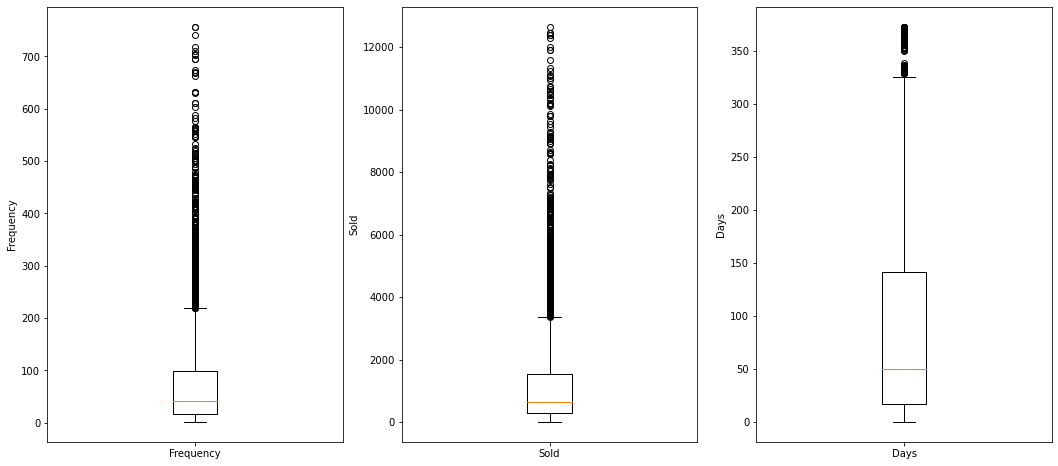

In [90]:
columns = ['Frequency', 'Sold', 'Days']
fig, axes = plt.subplots(1,3)
fig.set_size_inches(18,8)

for i,ax in enumerate(axes.flatten()):
    col=columns[i]
    ax.boxplot(retail[col], labels=[col])
    ax.set_ylabel(col)
    
plt.show()

# 2. K-Means model

## 2.1. Number of clusters

No one has told us in how many groups we should group customers, so we will let the model itself define the optimal value.

We will start by creating the Elbow curve to select the best number of clusters.

In [91]:
X = retail.values[:,1:]

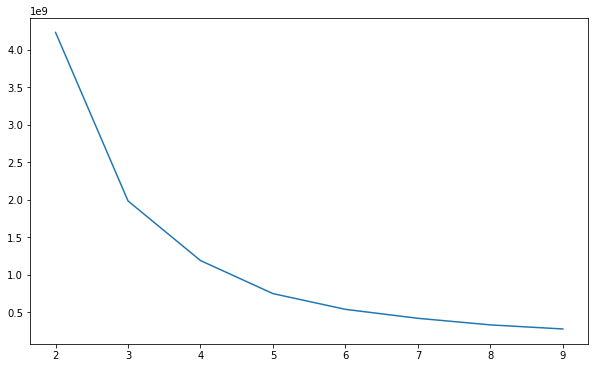

In [92]:
dist = []
clusters = [2, 3, 4, 5, 6, 7, 8, 9]
for cluster in clusters:
    k_means = KMeans(n_clusters=cluster, max_iter=50).fit(X)
    dist.append(k_means.inertia_)

plt.figure(figsize=(10,6))
plt.plot(clusters,dist)
plt.show()

The Elbow curve tells us, through a significant change in slope, what the number of clusters should be. In view of the results, 3 and 4 seem to achive it.

Let's plot the silhouette analysis to clarify this situation:

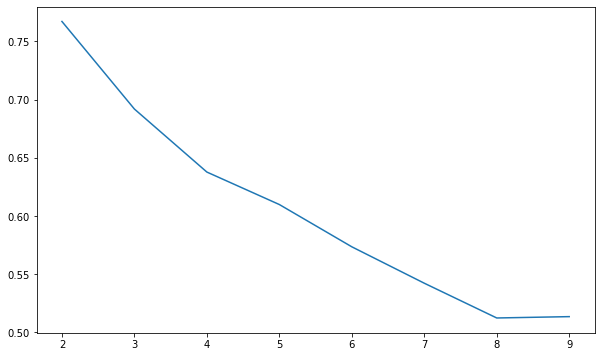

In [93]:
scores = []

for cluster in clusters:
    k_means = KMeans(n_clusters = cluster).fit(X)
    labels = k_means.labels_
    scores.append(silhouette_score(X, labels, metric = 'euclidean'))
    
plt.figure(figsize=(10,6))
plt.plot(clusters,scores)
plt.show()

Three clusters present a better value than 4, so we can conclude that the best value is 3.

## 2.2. Model

We will calculate to which cluster each customer belongs:

In [94]:
k_means = KMeans(init='k-means++', n_clusters=3, n_init=25)
k_means.fit(X)
labels = k_means.labels_

retail['Cluster'] = k_means.labels_
retail.head()

,CustomerID,Frequency,Sold,Days,Cluster
0,12347,182,4310.00,1,2
1,12348,31,1797.24,74,2
2,12349,73,1757.55,18,2
3,12350,17,334.40,309,0
4,12352,95,1545.41,35,0


## 2.3. Visual analysis

We don't know how the model has clustered, but we can inspect these values using boxplots:

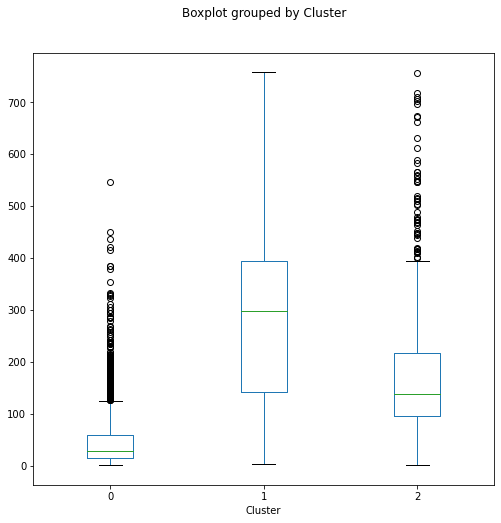

In [95]:
warnings.filterwarnings("ignore")
retail.boxplot(column='Frequency',by='Cluster',grid=False,figsize=(8,8))
plt.title(None)
plt.show()

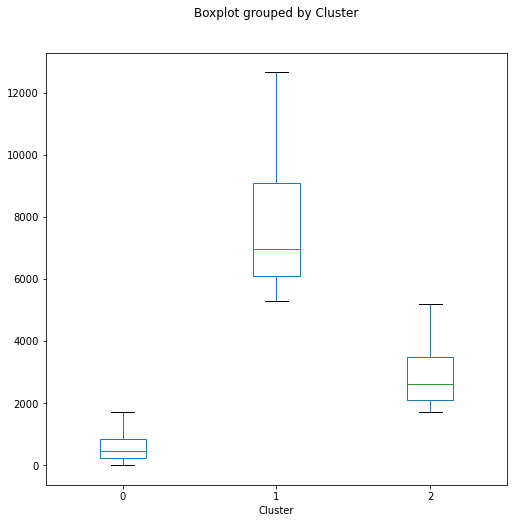

In [96]:
retail.boxplot(column='Sold',by='Cluster',grid=False,figsize=(8,8))
plt.title(None)
plt.show()

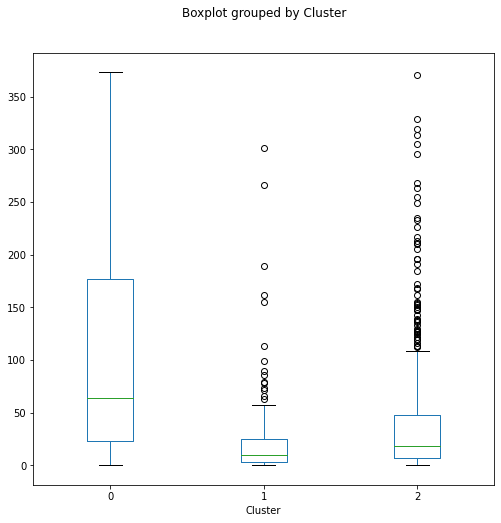

In [97]:
retail.boxplot(column='Days',by='Cluster', grid=False,figsize=(8,8))
plt.title(None)
plt.show()

Another way to visualize them is to present graphs that face the variables, using different colors for each cluster:

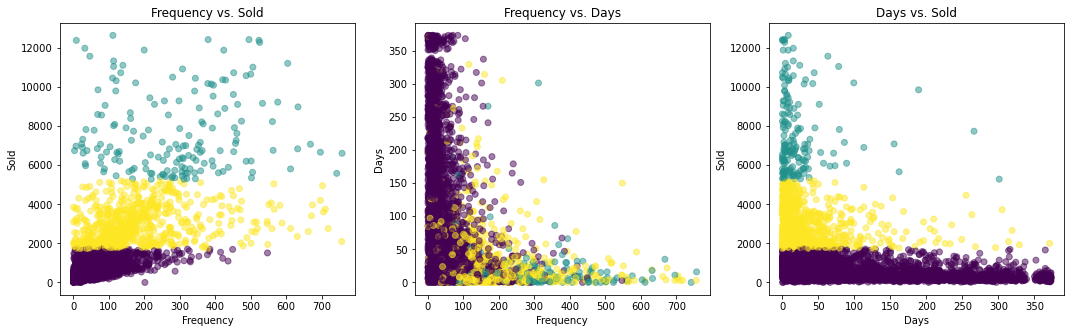

In [98]:
columns = ['Frequency', 'Sold', 'Days', 'Freq']
fig, axes = plt.subplots(1,3)
fig.set_size_inches(18,5)

for i,ax in enumerate(axes.flatten()):
    if i<2:
        j=0
        k=i+1
    else:
        j=i
        k=i-1
    
    ax.scatter(X[:,j], X[:,k], c=labels.astype(np.float), alpha=0.5)
    ax.set_xlabel(columns[j])
    ax.set_ylabel(columns[k])
    ax.set_title(columns[j] + ' vs. ' + columns[k])

plt.show()

## 2.4. Numerical analysis

Let's group the mean values to determine what types of customers include

In [99]:
grouped = retail.groupby('Cluster').mean()
grouped = grouped.astype({'Frequency':int, 'Sold':int, 'Days':int})
grouped

,Frequency,Sold,Days
Cluster,,,
0,45,578,107
1,288,7667,23
2,172,2859,36


According to the previous table, we can conclude the following:
<ul>
    <li><b>Cluster 0</b>: customers with purchases separated in time, few products and around 500€.</li>
    <li><b>Cluster 1</b>: customers buy a high number of products monthly and a very high amount (more than 7.000€).</li>
    <li><b>Cluster 2</b>: customers who also buy almost monthly, but less products and few money (around 3.000€).</li>
</ul>